# Colab Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""
Change directory to where this file is located
"""

%cd /content/drive/MyDrive/MLDL_lab/

/content/drive/MyDrive/MLDL_lab


In [ ]:
!pip install torchdata==0.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 13.8 MB/s 
     |████████████████████████████████| 140 kB 75.3 MB/s 
     |████████████████████████████████| 127 kB 58.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import torchtext
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [ ]:
%load_ext tensorboard

In [ ]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print("Using PyTorch version: {}, Device: {}".format(torch.__version__, DEVICE))
print("Using torchtext version: {}".format(torchtext.__version__))

Using PyTorch version: 1.12.1+cu113, Device: cuda
Using torchtext version: 0.13.1


# Utils

In [ ]:
def train(model, train_loader, criterion, optimizer, scheduler=None):
    model.train()
    train_loss = 0
    correct = 0
    tqdm_bar = tqdm(train_loader)
    for batch_idx, (image, label) in enumerate(tqdm_bar):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        train_loss += loss.item()
        prediction = output.max(1, keepdim = True)[1]
        correct += prediction.eq(label.view_as(prediction)).sum().item()
        optimizer.step()
        tqdm_bar.set_description("Epoch {} - train loss: {:.6f}".format(epoch, loss.item()))
    if scheduler is not None:
        scheduler.step()
    train_loss /= len(train_loader.dataset)
    train_acc = 100. * correct / len(train_loader.dataset)
    return train_loss, train_acc


def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in tqdm(test_loader):
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)
    return test_loss, test_acc

In [ ]:
def plot_history(history):
    plt.figure(figsize=(3 * 13, 4))
    plt.subplot(1, 5, 1)
    plt.title("Training and Validation Loss")
    plt.plot(history['train_loss'], label="train_loss")
    plt.plot(history['test_loss'], label="test_loss")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(1, 5, 2)
    plt.title("Training and Validation Accuracy")
    plt.plot(history['train_acc'], label="train_acc")
    plt.plot(history['test_acc'], label="test_acc")
    plt.xlabel("iterations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.subplot(1, 5, 3)
    plt.title("Learning Rate")
    plt.plot(history['lr'], label="learning rate")
    plt.xlabel("iterations")
    plt.ylabel("LR")
    plt.show()

In [ ]:
def plot_dataset(dataloader, grid_width=8, grid_height=2, figure_width=12, figure_height=3, y_hats=None):
    images, labels = next(iter(dataloader))
    f, ax = plt.subplots(grid_height, grid_width)
    f.set_size_inches(figure_width, figure_height)
    img_idx = 0
    for i in range(0, grid_height):
        for j in range(0, grid_width):
            image = images[img_idx]
            label = labels[img_idx]
            title_color = 'k'
            if y_hats is None:
                label_idx = int(label)
            else:
                label_idx = int(y_hats[img_idx])
                if int(labels[img_idx]) != label_idx:
                    title_color = 'r'
            label = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'][label_idx]
            ax[i][j].axis('off')
            ax[i][j].set_title(label, color=title_color)
            image = image.squeeze(axis=0)
            ax[i][j].imshow(image, cmap=plt.get_cmap('gray'))
            img_idx += 1
        plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0.25)
    plt.show()

# Load Fashion MNIST

In [ ]:
BATCH_SIZE = 1024
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data/', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=False)

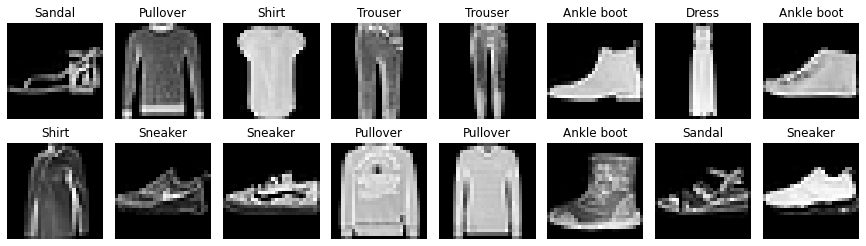

In [ ]:
plot_dataset(train_loader)

# Practice 1. Regularization

## Question1. Training without regularization

In [ ]:
class SimpleClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)  
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 1], 	LR: 0.0010, 	Train Loss: 0.0008, 	Train Accuracy: 71.52 %, 	Test Loss: 0.0005, 	Test Accuracy: 81.53 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 2], 	LR: 0.0010, 	Train Loss: 0.0004, 	Train Accuracy: 83.63 %, 	Test Loss: 0.0005, 	Test Accuracy: 82.47 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 3], 	LR: 0.0010, 	Train Loss: 0.0004, 	Train Accuracy: 85.81 %, 	Test Loss: 0.0004, 	Test Accuracy: 85.01 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 4], 	LR: 0.0010, 	Train Loss: 0.0004, 	Train Accuracy: 87.03 %, 	Test Loss: 0.0004, 	Test Accuracy: 86.20 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 5], 	LR: 0.0010, 	Train Loss: 0.0003, 	Train Accuracy: 87.84 %, 	Test Loss: 0.0004, 	Test Accuracy: 86.40 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 6], 	LR: 0.0010, 	Train Loss: 0.0003, 	Train Accuracy: 88.28 %, 	Test Loss: 0.0004, 	Test Accuracy: 87.17 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 7], 	LR: 0.0010, 	Train Loss: 0.0003, 	Train Accuracy: 88.99 %, 	Test Loss: 0.0004, 	Test Accuracy: 87.04 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 8], 	LR: 0.0010, 	Train Loss: 0.0003, 	Train Accuracy: 89.14 %, 	Test Loss: 0.0004, 	Test Accuracy: 86.82 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 9], 	LR: 0.0010, 	Train Loss: 0.0003, 	Train Accuracy: 89.79 %, 	Test Loss: 0.0003, 	Test Accuracy: 87.61 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 10], 	LR: 0.0010, 	Train Loss: 0.0003, 	Train Accuracy: 90.21 %, 	Test Loss: 0.0004, 	Test Accuracy: 87.52 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 11], 	LR: 0.0010, 	Train Loss: 0.0003, 	Train Accuracy: 90.23 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.00 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 12], 	LR: 0.0010, 	Train Loss: 0.0002, 	Train Accuracy: 90.78 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.35 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 13], 	LR: 0.0010, 	Train Loss: 0.0002, 	Train Accuracy: 91.09 %, 	Test Loss: 0.0003, 	Test Accuracy: 87.69 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 14], 	LR: 0.0010, 	Train Loss: 0.0002, 	Train Accuracy: 91.14 %, 	Test Loss: 0.0003, 	Test Accuracy: 87.93 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 15], 	LR: 0.0010, 	Train Loss: 0.0002, 	Train Accuracy: 91.58 %, 	Test Loss: 0.0003, 	Test Accuracy: 87.94 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 16], 	LR: 0.0010, 	Train Loss: 0.0002, 	Train Accuracy: 91.70 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.05 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 17], 	LR: 0.0010, 	Train Loss: 0.0002, 	Train Accuracy: 92.03 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.43 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 18], 	LR: 0.0010, 	Train Loss: 0.0002, 	Train Accuracy: 92.26 %, 	Test Loss: 0.0003, 	Test Accuracy: 87.94 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 19], 	LR: 0.0010, 	Train Loss: 0.0002, 	Train Accuracy: 92.38 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.52 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 20], 	LR: 0.0010, 	Train Loss: 0.0002, 	Train Accuracy: 92.85 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.73 % 



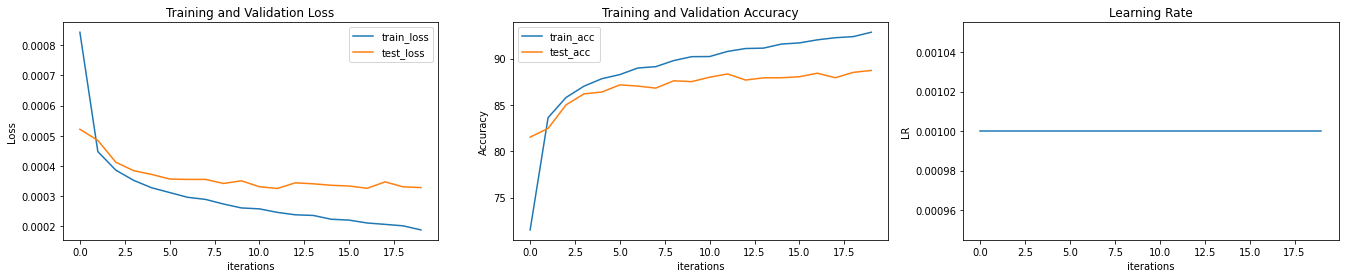

In [ ]:
EPOCHS = 20
model = SimpleClassifier().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
history = {'train_loss':[], 'train_acc':[], 'test_loss':[], 'test_acc':[], 'lr':[]}

for epoch in range(1, EPOCHS + 1):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader, criterion)
    print("\n[EPOCH: {}], \tLR: {:.4f}, \tTrain Loss: {:.4f}, \tTrain Accuracy: {:.2f} %, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, optimizer.param_groups[0]['lr'], train_loss, train_accuracy, test_loss, test_accuracy))
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_accuracy)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_accuracy)
    history['lr'].append(optimizer.param_groups[0]['lr'])
    
plot_history(history)

## Question2. Custom Dropout

In [ ]:
"""
(1) Implement customized Dropout class.

  - "p" is a probability to keep neurons active. Lower p, more elements to be zeroed.
  - dropout should be deactivated during evaluation.
"""
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        if p <= 0 or p >= 1:
            raise ValueError("dropout probability has to be between 0 and 1, "
                             "but got {}".format(p))
        self.p = p

    def forward(self, input):
        ########## Your Code #########
        
        mask = (np.random.rand(*input.shape) < self.p) / self.p # p개를 가려준다       
                
        output = input * torch.Tensor(mask).to(DEVICE) # mask tensor도 DEVICE로
        output = output.to(DEVICE)
        ##############################
        return output

    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + str(self.p) + ')'

In [ ]:
# Generate random tensor
x = torch.rand(10)
x

tensor([0.8216, 0.2811, 0.6757, 0.1003, 0.1448, 0.7341, 0.3140, 0.9608, 0.5702,
        0.9163])

In [ ]:
# "p" of the elements remain active after dropout
dropout = Dropout(p=0.5)
print(dropout)
print(dropout(x))

dropout = Dropout(p=0.999)
print(dropout)
print(dropout(x))

dropout = Dropout(p=0.001)
print(dropout)
print(dropout(x))

Dropout(p=0.5)
tensor([0.0000, 0.0000, 1.3514, 0.0000, 0.0000, 0.0000, 0.6279, 1.9215, 0.0000,
        0.0000], device='cuda:0')
Dropout(p=0.999)
tensor([0.8224, 0.2814, 0.6764, 0.1004, 0.1449, 0.7349, 0.3143, 0.9617, 0.5708,
        0.9172], device='cuda:0')
Dropout(p=0.001)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


In [ ]:
# Dropout should be deactivated during evaluation
dropout = Dropout(p=0.5)
dropout.eval()
dropout(x)

tensor([0.0000, 0.5623, 1.3514, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:0')

In [ ]:
"""
(2) Train the model with custom dropout layer.
"""

class RegClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = Dropout(p=0.5)
    
    def forward(self,x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        
        return x

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 1], 	LR: 0.0010, 	Train Loss: 0.0012, 	Train Accuracy: 56.01 %, 	Test Loss: 0.0008, 	Test Accuracy: 72.33 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 2], 	LR: 0.0010, 	Train Loss: 0.0007, 	Train Accuracy: 76.86 %, 	Test Loss: 0.0006, 	Test Accuracy: 78.75 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 3], 	LR: 0.0010, 	Train Loss: 0.0005, 	Train Accuracy: 81.07 %, 	Test Loss: 0.0006, 	Test Accuracy: 81.38 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 4], 	LR: 0.0010, 	Train Loss: 0.0005, 	Train Accuracy: 82.93 %, 	Test Loss: 0.0005, 	Test Accuracy: 82.10 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 5], 	LR: 0.0010, 	Train Loss: 0.0005, 	Train Accuracy: 83.93 %, 	Test Loss: 0.0005, 	Test Accuracy: 83.05 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 6], 	LR: 0.0010, 	Train Loss: 0.0004, 	Train Accuracy: 84.71 %, 	Test Loss: 0.0005, 	Test Accuracy: 83.75 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 7], 	LR: 0.0010, 	Train Loss: 0.0004, 	Train Accuracy: 85.32 %, 	Test Loss: 0.0005, 	Test Accuracy: 84.03 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 8], 	LR: 0.0010, 	Train Loss: 0.0004, 	Train Accuracy: 85.60 %, 	Test Loss: 0.0005, 	Test Accuracy: 84.48 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 9], 	LR: 0.0010, 	Train Loss: 0.0004, 	Train Accuracy: 86.00 %, 	Test Loss: 0.0005, 	Test Accuracy: 84.04 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 10], 	LR: 0.0010, 	Train Loss: 0.0004, 	Train Accuracy: 86.18 %, 	Test Loss: 0.0005, 	Test Accuracy: 84.48 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 11], 	LR: 0.0010, 	Train Loss: 0.0004, 	Train Accuracy: 86.35 %, 	Test Loss: 0.0005, 	Test Accuracy: 84.47 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 12], 	LR: 0.0010, 	Train Loss: 0.0004, 	Train Accuracy: 86.38 %, 	Test Loss: 0.0005, 	Test Accuracy: 84.84 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 13], 	LR: 0.0010, 	Train Loss: 0.0004, 	Train Accuracy: 86.90 %, 	Test Loss: 0.0005, 	Test Accuracy: 85.02 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 14], 	LR: 0.0010, 	Train Loss: 0.0004, 	Train Accuracy: 86.92 %, 	Test Loss: 0.0004, 	Test Accuracy: 85.49 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 15], 	LR: 0.0010, 	Train Loss: 0.0004, 	Train Accuracy: 87.37 %, 	Test Loss: 0.0004, 	Test Accuracy: 85.31 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 16], 	LR: 0.0010, 	Train Loss: 0.0004, 	Train Accuracy: 87.48 %, 	Test Loss: 0.0004, 	Test Accuracy: 85.61 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 17], 	LR: 0.0010, 	Train Loss: 0.0004, 	Train Accuracy: 87.67 %, 	Test Loss: 0.0004, 	Test Accuracy: 85.58 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 18], 	LR: 0.0010, 	Train Loss: 0.0003, 	Train Accuracy: 87.81 %, 	Test Loss: 0.0004, 	Test Accuracy: 86.00 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 19], 	LR: 0.0010, 	Train Loss: 0.0003, 	Train Accuracy: 87.77 %, 	Test Loss: 0.0004, 	Test Accuracy: 85.38 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 20], 	LR: 0.0010, 	Train Loss: 0.0003, 	Train Accuracy: 87.88 %, 	Test Loss: 0.0004, 	Test Accuracy: 85.69 % 



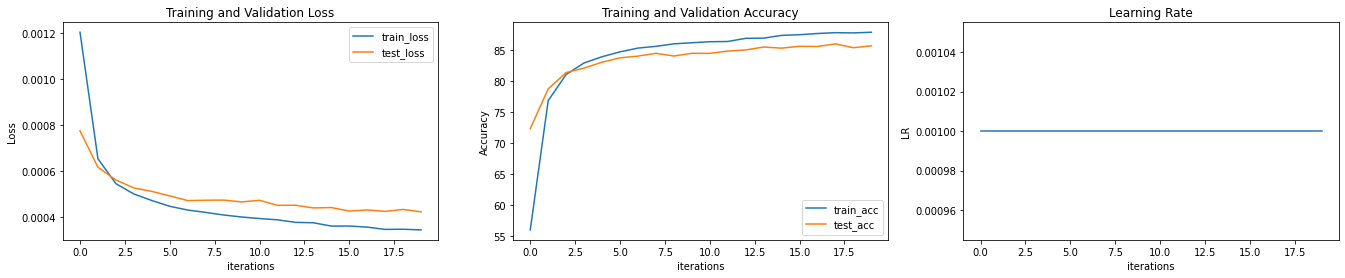

In [ ]:
EPOCHS = 20
model = RegClassifier().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
history = {'train_loss':[], 'train_acc':[], 'test_loss':[], 'test_acc':[], 'lr':[]}

for epoch in range(1, EPOCHS + 1):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader, criterion)
    print("\n[EPOCH: {}], \tLR: {:.4f}, \tTrain Loss: {:.4f}, \tTrain Accuracy: {:.2f} %, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, optimizer.param_groups[0]['lr'], train_loss, train_accuracy, test_loss, test_accuracy))
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_accuracy)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_accuracy)
    history['lr'].append(optimizer.param_groups[0]['lr'])
    
plot_history(history)

## Question3. Early Stopping

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=8),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, 10),
        )
    
    def forward(self,x):
        x = self.conv(x)
        return x

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 1], 	LR: 0.0009, 	Train Loss: 0.0007, 	Train Accuracy: 73.57 %, 	Test Loss: 0.0005, 	Test Accuracy: 83.65 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 2], 	LR: 0.0008, 	Train Loss: 0.0004, 	Train Accuracy: 84.16 %, 	Test Loss: 0.0004, 	Test Accuracy: 85.93 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 3], 	LR: 0.0007, 	Train Loss: 0.0004, 	Train Accuracy: 86.06 %, 	Test Loss: 0.0004, 	Test Accuracy: 86.54 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 4], 	LR: 0.0007, 	Train Loss: 0.0004, 	Train Accuracy: 86.62 %, 	Test Loss: 0.0004, 	Test Accuracy: 86.75 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 5], 	LR: 0.0006, 	Train Loss: 0.0003, 	Train Accuracy: 87.32 %, 	Test Loss: 0.0004, 	Test Accuracy: 87.55 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 6], 	LR: 0.0005, 	Train Loss: 0.0003, 	Train Accuracy: 87.80 %, 	Test Loss: 0.0004, 	Test Accuracy: 87.22 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 7], 	LR: 0.0005, 	Train Loss: 0.0003, 	Train Accuracy: 88.26 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.46 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 8], 	LR: 0.0004, 	Train Loss: 0.0003, 	Train Accuracy: 88.40 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.46 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 9], 	LR: 0.0004, 	Train Loss: 0.0003, 	Train Accuracy: 88.86 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.77 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 10], 	LR: 0.0003, 	Train Loss: 0.0003, 	Train Accuracy: 89.09 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.92 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 11], 	LR: 0.0003, 	Train Loss: 0.0003, 	Train Accuracy: 89.42 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.78 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 12], 	LR: 0.0003, 	Train Loss: 0.0003, 	Train Accuracy: 89.75 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.86 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 13], 	LR: 0.0003, 	Train Loss: 0.0003, 	Train Accuracy: 89.78 %, 	Test Loss: 0.0003, 	Test Accuracy: 89.14 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 14], 	LR: 0.0002, 	Train Loss: 0.0003, 	Train Accuracy: 90.11 %, 	Test Loss: 0.0003, 	Test Accuracy: 89.64 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 15], 	LR: 0.0002, 	Train Loss: 0.0003, 	Train Accuracy: 90.06 %, 	Test Loss: 0.0003, 	Test Accuracy: 89.15 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 16], 	LR: 0.0002, 	Train Loss: 0.0003, 	Train Accuracy: 90.20 %, 	Test Loss: 0.0003, 	Test Accuracy: 89.76 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 17], 	LR: 0.0002, 	Train Loss: 0.0003, 	Train Accuracy: 90.43 %, 	Test Loss: 0.0003, 	Test Accuracy: 89.62 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 18], 	LR: 0.0002, 	Train Loss: 0.0003, 	Train Accuracy: 90.57 %, 	Test Loss: 0.0003, 	Test Accuracy: 89.47 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 19], 	LR: 0.0001, 	Train Loss: 0.0003, 	Train Accuracy: 90.75 %, 	Test Loss: 0.0003, 	Test Accuracy: 89.81 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 20], 	LR: 0.0001, 	Train Loss: 0.0003, 	Train Accuracy: 90.71 %, 	Test Loss: 0.0003, 	Test Accuracy: 89.87 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 21], 	LR: 0.0001, 	Train Loss: 0.0003, 	Train Accuracy: 90.81 %, 	Test Loss: 0.0003, 	Test Accuracy: 89.96 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 22], 	LR: 0.0001, 	Train Loss: 0.0003, 	Train Accuracy: 90.87 %, 	Test Loss: 0.0003, 	Test Accuracy: 89.86 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 23], 	LR: 0.0001, 	Train Loss: 0.0003, 	Train Accuracy: 90.97 %, 	Test Loss: 0.0003, 	Test Accuracy: 90.07 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 24], 	LR: 0.0001, 	Train Loss: 0.0003, 	Train Accuracy: 91.07 %, 	Test Loss: 0.0003, 	Test Accuracy: 90.11 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 25], 	LR: 0.0001, 	Train Loss: 0.0003, 	Train Accuracy: 91.15 %, 	Test Loss: 0.0003, 	Test Accuracy: 90.28 % 



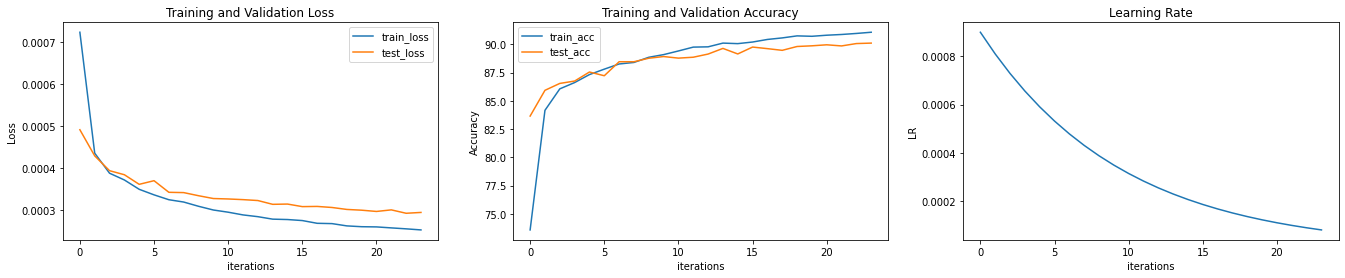

In [ ]:
"""
(1) Implement early stopping.

  - Use the variables "best_loss" and "patience".
  - If the test_loss does not improve after 2 epochs, stop the training.
"""
from torch.optim.lr_scheduler import ExponentialLR as ExponentialLR

#### Use these variables to implement early stopping ####
best_loss = 100
patience = 0
#########################################################

EPOCHS = 30
history = {'train_loss':[], 'train_acc':[], 'test_loss':[], 'test_acc':[], 'lr':[]}

model = Model().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.9)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, EPOCHS + 1):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, scheduler)
    test_loss, test_accuracy = evaluate(model, test_loader, criterion)
    print("\n[EPOCH: {}], \tLR: {:.4f}, \tTrain Loss: {:.4f}, \tTrain Accuracy: {:.2f} %, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, optimizer.param_groups[0]['lr'], train_loss, train_accuracy, test_loss, test_accuracy))

    ########## Your Code #########
    if test_loss < best_loss:
      best_loss = test_loss
      patience = 0
    else:
      patience += 1
      if patience >= 2:
        break
    ##############################

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_accuracy)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_accuracy)
    history['lr'].append(optimizer.param_groups[0]['lr'])
    
plot_history(history)

# Practice2. Learning Rate Scheduler

In [ ]:
"""
(1) Implement customized learning rate scheduler.
"""

class ScheduledOptim():
    def __init__(self, optimizer, n_warmup_steps, decay_rate, steps=None):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.decay = decay_rate
        self.n_steps = 0
        self.steps = steps
        self.initial_lr = optimizer.param_groups[0]['lr']
        self.current_lr = optimizer.param_groups[0]['lr']

    def zero_grad(self):
        self._optimizer.zero_grad()

    def step(self):
        # self._optimizer.step()
        self.update()
    
    def get_lr(self):
        return self.current_lr
    
    def update(self):
        """
        Update the learning rate.

        - During the first self.n_warmup_steps, gradually increase the learning rate from 0 to the self.initial_lr.
        - Then, decay the learning rate with the given probability self.decay at each decay steps self.steps.
        - If decay steps are not given, decay the learning rate on every epoch.
        """
        ########## Your Code #########
        lr = None
        if self.n_steps < self.n_warmup_steps:
          lr = self.n_steps / self.n_warmup_steps * self.initial_lr
        elif self.n_steps == self.n_warmup_steps:
          lr = self.initial_lr
        else:
          if self.steps is None:
            lr = self.current_lr * self.decay
          else:
            if self.n_steps in self.steps:
              lr = self.current_lr * self.decay
            else:
              lr = self.current_lr

        self.current_lr = lr
        for param_group in self._optimizer.param_groups:
            param_group['lr'] = self.current_lr
        ##############################

        self.n_steps += 1

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 1], 	LR: 0.00033, 	Train Loss: 0.0023, 	Train Accuracy: 9.05 %, 	Test Loss: 0.0023, 	Test Accuracy: 7.70 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 2], 	LR: 0.00067, 	Train Loss: 0.0008, 	Train Accuracy: 72.48 %, 	Test Loss: 0.0005, 	Test Accuracy: 82.67 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 3], 	LR: 0.00100, 	Train Loss: 0.0004, 	Train Accuracy: 84.32 %, 	Test Loss: 0.0004, 	Test Accuracy: 86.30 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 4], 	LR: 0.00090, 	Train Loss: 0.0004, 	Train Accuracy: 86.27 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.03 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 5], 	LR: 0.00081, 	Train Loss: 0.0003, 	Train Accuracy: 88.11 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.44 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 6], 	LR: 0.00073, 	Train Loss: 0.0003, 	Train Accuracy: 89.05 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.76 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 7], 	LR: 0.00066, 	Train Loss: 0.0003, 	Train Accuracy: 89.80 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.98 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 8], 	LR: 0.00059, 	Train Loss: 0.0003, 	Train Accuracy: 90.17 %, 	Test Loss: 0.0003, 	Test Accuracy: 89.84 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 9], 	LR: 0.00053, 	Train Loss: 0.0003, 	Train Accuracy: 90.57 %, 	Test Loss: 0.0003, 	Test Accuracy: 90.26 % 



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 10], 	LR: 0.00048, 	Train Loss: 0.0002, 	Train Accuracy: 91.17 %, 	Test Loss: 0.0003, 	Test Accuracy: 90.29 % 



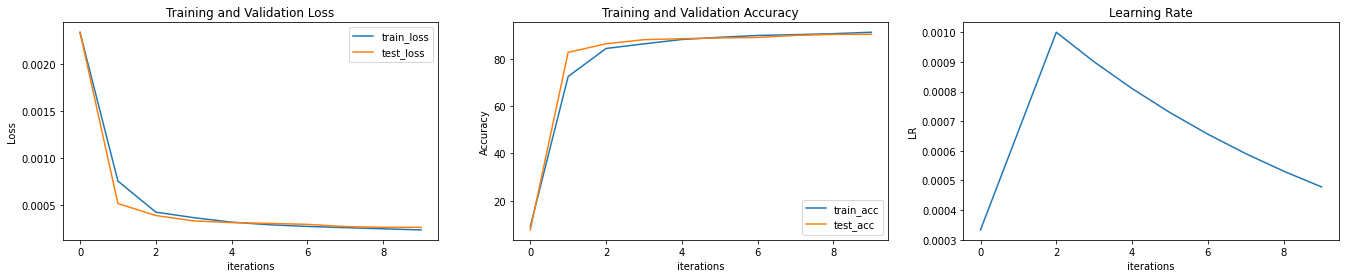

In [ ]:
EPOCHS = 10
history = {'train_loss':[], 'train_acc':[], 'test_loss':[], 'test_acc':[], 'lr':[]}

model = Model().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

scheduler = ScheduledOptim(optimizer, n_warmup_steps=3, decay_rate=0.9)
scheduler.update()

for epoch in range(1, EPOCHS + 1):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, scheduler)
    test_loss, test_accuracy = evaluate(model, test_loader, criterion)
    lr = scheduler.get_lr()
    print("\n[EPOCH: {}], \tLR: {:.5f}, \tTrain Loss: {:.4f}, \tTrain Accuracy: {:.2f} %, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, lr, train_loss, train_accuracy, test_loss, test_accuracy))
   
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_accuracy)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_accuracy)
    history['lr'].append(lr)
    
plot_history(history)

# Practice3. RNN Text Classification

## Question1. Preprocess AG News dataset

In [ ]:
train_data, test_data = torchtext.datasets.AG_NEWS(root='./')
labels = [_, 'World', 'Sports', 'Business', 'Sci/Tech']

In [ ]:
"""
(1) Print the 1st element of the train_data.
"""

y, x = next(iter(train_data))
print(labels[y])
print(x)

Business
Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


In [ ]:
"""
(2) Check the value of labels in the train_data and test_data.
"""

########## Your Code #########
set([label for (label, text) in train_data]), set([label for (label, text) in test_data])
##############################

({1, 2, 3, 4}, {1, 2, 3, 4})

In [ ]:
"""
(3) Tokenize the sentence with the "get_tokenizer" function.

  - Reference: https://pytorch.org/text/stable/data_utils.html#get-tokenizer
"""

from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('basic_english')

sample_sentence = "I love MLDL1 class so much!" # Modify the sample and see what the function does.
tokenizer(sample_sentence)

['i', 'love', 'mldl1', 'class', 'so', 'much', '!']

In [ ]:
"""
(4) Encode the tokens with the "build_vocab_from_iterator" function.

  - Reference: https://pytorch.org/text/stable/vocab.html#build-vocab-from-iterator
"""

from torchtext.vocab import build_vocab_from_iterator

def tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

train_iterator = tokens(train_data)
encoder = build_vocab_from_iterator(train_iterator, specials=["<unk>"])
encoder.set_default_index(encoder["<unk>"])

encoder(tokenizer("I love MLDL1 <unk> class !"))

[282, 2320, 0, 0, 2644, 764]

In [ ]:
"""
(5) Get the processed data of the 1st element in train_data using text_pipeline and label_pipeline.
"""

text_pipeline = lambda x: encoder(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

########## Your Code #########
print("Before preprocessing")
y, x = next(iter(train_data))
print(y)
print(x)

print("\nAfter preprocessing")
y_p, x_p = label_pipeline(y), text_pipeline(x)
print(y_p)
print(x_p)
##############################

Before preprocessing
3
Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.

After preprocessing
2
[431, 425, 1, 1605, 14838, 113, 66, 2, 848, 13, 27, 14, 27, 15, 50725, 3, 431, 374, 16, 9, 67507, 6, 52258, 3, 42, 4009, 783, 325, 1]


## Question2. Customized collate_batch

In [ ]:
iterator = iter(train_data)
sample_batch = []
for _ in range(8):
    sample_batch.append(next(iterator))

print(sample_batch)

[(3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."), (3, 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.'), (3, "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums."), (3, 'Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\\flows from the main pipeline in southern Iraq after\\intelligence showed a rebel militia could strike\\infrastructure, an oil official said on Saturday.'), (3, 'Oil prices soar to all-time record, posing new men

In [ ]:
"""
(1) The collate_batch function below is designed to process AG News dataset. What is the problem of this function?
"""

def collate_batch(batch):
    label_list, text_list = [], []
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = torch.stack(text_list).long()
    return label_list, text_list

collate_batch(sample_batch)

RuntimeError: ignored

In [ ]:
"""
(2) Unify the lengths of the sentences in the batch to MAX_LEN.

  - If the sentence length is less than MAX_LEN, pad zeroes at the end of the sentence.
  - If the sentence length is greater than MAX_LEN, cut the tails of the sentence.
"""

MAX_LEN = 32

def collate_batch(batch):
    ########## Your Code #########
    label_list, text_list = [], []
    for (_label, _text) in batch:
      label_list.append(label_pipeline(_label))
      processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
      if processed_text.size(0) >= MAX_LEN: ###
        processed_text = processed_text[:MAX_LEN] ### slicing
      else:
        processed_text = torch.cat([processed_text, ###
                                    torch.zeros(MAX_LEN - processed_text.size(0))]) ### zero padding
      text_list.append(processed_text)
    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list =torch.stack(text_list).long()
    return label_list, text_list
    ##############################

In [ ]:
collate_batch(sample_batch)

(tensor([2, 2, 2, 2, 2, 2, 2, 2]),
 tensor([[  431,   425,     1,  1605, 14838,   113,    66,     2,   848,    13,
             27,    14,    27,    15, 50725,     3,   431,   374,    16,     9,
          67507,     6, 52258,     3,    42,  4009,   783,   325,     1,     0,
              0,     0],
         [15874,  1072,   854,  1310,  4250,    13,    27,    14,    27,    15,
            929,   797,   320, 15874,    98,     3, 27657,    28,     5,  4459,
             11,   564, 52790,     8, 80617,  2125,     7,     2,   525,   241,
              3,    28],
         [   58,     8,   347,  4582,   151,    16,   738,    13,    27,    14,
             27,    15,  2384,   452,    92,  2059, 27360,     2,   347,     8,
              2,   738,    11,   271,    42,   240, 51953,    38,     2,   294,
            126,   112],
         [   70,  7376,    58,  1810,    29,   905,   537,  2846,    13,    27,
             14,    27,    15,   838,    39,  4978,    58, 68871,    29,     2,
          

## Question3. Text Classification Model

In [ ]:
def train(model, train_loader, criterion, optimizer, scheduler=None):
    model.train()
    train_loss = 0
    correct = 0
    tqdm_bar = tqdm(train_loader)

    for label, text in tqdm_bar:
        text = text.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(text)
        loss = criterion(output, label)
        loss.backward()
        train_loss += loss.item()
        prediction = output.max(1, keepdim = True)[1]
        correct += prediction.eq(label.view_as(prediction)).sum().item()
        optimizer.step()
        tqdm_bar.set_description("Epoch {} - train loss: {:.6f}".format(epoch, loss.item()))
    if scheduler is not None:
        scheduler.step()
    train_loss /= len(train_loader.dataset)
    train_acc = 100. * correct / len(train_loader.dataset)
    return train_loss, train_acc


def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for label, text in tqdm(test_loader):
            text = text.to(DEVICE)
            label = label.to(DEVICE)
            output = model(text)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)
    return test_loss, test_acc

In [ ]:
"""
(1) Print the shape of the sample data x and y.
"""

from torchtext.data.functional import to_map_style_dataset

train_dataset = to_map_style_dataset(train_data) # GET ITEM 등등 자동으로
test_dataset = to_map_style_dataset(test_data)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                              shuffle=False, collate_fn=collate_batch)

y, x = next(iter(train_dataloader))
print(x.shape)
print(y.shape)

torch.Size([1024, 32])
torch.Size([1024])


In [ ]:
"""
(2) Use nn.Embedding() to get embedding vectors of x.
"""

vocab_size = len(encoder)
emb_size = 64

########## Your Code #########
embedding = nn.Embedding(vocab_size, emb_size)
embedded_x = embedding(x)
##############################
print(embedded_x.shape)

torch.Size([1024, 32, 64])


In [ ]:
"""
(3) Implement RNN layer using given variables.
"""

vocab_size = len(encoder)
emb_size = 64
hidden_dim = 64
num_layers = 1

########## Your Code #########
rnn = nn.RNN(
    input_size=emb_size,
    hidden_size=hidden_dim,
    num_layers=num_layers,
    batch_first=True
)
##############################

h_0 = torch.randn(num_layers, BATCH_SIZE, hidden_dim)
output, h_n = rnn(embedded_x, h_0)
print(output.shape) # -> torch.Size([BATCH_SIZE, seq_len, hidden_dim])
print(h_n.shape) # -> torch.Size([num_layers, BATCH_SIZE, hidden_dim])

torch.Size([1024, 32, 64])
torch.Size([1, 1024, 64])


In [ ]:
"""
(4) Implement TextClassficationModel.
"""

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, hidden, embed, num_class, batch_size):
        """
        - Define self.embedding and self.rnn layer same as in Q(2) and Q(3).
        - self.fc layer maps the average of output hidden units to the target classes.
        """
        super(TextClassificationModel, self).__init__()
        ########## Your Code #########
        self.embedding = nn.Embedding(vocab_size, embed)
        self.rnn = nn.RNN(input_size = embed, hidden_size = hidden,
                          num_layers = 1,
                          nonlinearity='tanh',
                          bias=True, batch_first=True)
        self.fc = nn.Linear(hidden, num_class)
        ##############################
        self.init_weights()

    def init_weights(self):
        init_range = 0.5
        self.embedding.weight.data.uniform_(-init_range, init_range)
        self.fc.weight.data.uniform_(-init_range, init_range)
        self.fc.bias.data.zero_()

    def forward(self, x):
        """
        1) Get embedded_x using self.embedding layer.
        2) Get output hidden units using self.rnn layer.
        3) Calculate the average of output hidden layers.
        4) Map the average of output hidden layers to the target classes.
        """
        ########## Your Code #########
        out = self.embedding(x)
        out, h = self.rnn(out)
        out = torch.mean(out, dim=1)
        out = self.fc(out)
        return out
        ##############################

In [ ]:
"""
(5) Train the model and visualize your experiments with TensorBoard (Train/Validation Loss and Accuracy)
"""

########## Your Code #########
EPOCHS = 5
LR = 1
BATCH_SIZE = 64
num_class = len(set([label for (label, text) in train_data]))
vocab_size = len(encoder)
emsize = 64
hidden_dim = 32
##############################

model = TextClassificationModel(vocab_size, hidden_dim, emsize, num_class, BATCH_SIZE).to(DEVICE)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None

train_dataset = to_map_style_dataset(train_data)
test_dataset = to_map_style_dataset(test_data)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)

########## Your Code #########
writer = SummaryWriter(log_dir="./logs")

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train(model, train_dataloader, criterion, optimizer, scheduler)
    val_loss, val_acc = evaluate(model, valid_dataloader, criterion)
    print("\n[EPOCH: {}], \tTrain Loss: {:.4f}, \tTrain Accuracy: {:.2f} %, \tValid Loss: {:.4f}, \tValid Accuracy: {:.2f} % \n".format(
        epoch, train_loss, train_acc, val_loss, val_acc))

writer.flush()
writer.close()
##############################

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]


[EPOCH: 1], 	Train Loss: 0.0114, 	Train Accuracy: 70.28 %, 	Valid Loss: 0.0070, 	Valid Accuracy: 84.17 % 



  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]


[EPOCH: 2], 	Train Loss: 0.0059, 	Train Accuracy: 86.77 %, 	Valid Loss: 0.0063, 	Valid Accuracy: 85.51 % 



  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]


[EPOCH: 3], 	Train Loss: 0.0056, 	Train Accuracy: 87.37 %, 	Valid Loss: 0.0063, 	Valid Accuracy: 85.89 % 



  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]


[EPOCH: 4], 	Train Loss: 0.0056, 	Train Accuracy: 87.43 %, 	Valid Loss: 0.0062, 	Valid Accuracy: 85.97 % 



  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]


[EPOCH: 5], 	Train Loss: 0.0056, 	Train Accuracy: 87.43 %, 	Valid Loss: 0.0062, 	Valid Accuracy: 85.97 % 



In [ ]:
%tensorboard --logdir ./logs

Reusing TensorBoard on port 6006 (pid 576), started 0:06:24 ago. (Use '!kill 576' to kill it.)

<IPython.core.display.Javascript object>

In [ ]:
# Run this cell and you will get the shared link for Tensorboard

!tensorboard dev upload --logdir ./logs \
  --name "MLDL1 Lab3" \
  --description "Training results from Lab3" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=pl6xs1eonyCEILiHKpl9eszgcHndUT&prompt=consent&access_type=offline
Enter 